# Dissertation Analysis Part 1

This notebook spatially joins the infrastructure data with the LSOA and Datazone shapefiles, scales the values to account for inflation, and sums the values by the bespoke categories discussed in the report.
  
  
  The dataframes are exported at the end of this for use in parts 2 and 3.

### Importing Packages and Defining Functions

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay
import datetime
import pysal as ps
from pysal.contrib.viz import mapping as maps
import mapclassify.classifiers as classifiers


import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.metrics import r2_score

from matplotlib.colors import ListedColormap
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt



import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

#visualisation set
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

from IPython.display import HTML


C:\Users\Yasmine Hujair\anaconda32020\envs\Dissertation\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Reading in Data

##### Index of Multiple Deprivation
England and Wales

In [3]:
#Index of Multiple Deprivation 2019 (England)
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter/main/Data/IMD2019.csv'
# Read in data from github
IMD19 = pd.read_csv(url, low_memory=False)

In [4]:
#Index of Multiple Deprivation 2015 (England)
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter/main/Data/IMD2015.csv'
# Read in data from github
IMD15 = pd.read_csv(url, low_memory=False)

In [5]:
#Index of Multiple Deprivation England and Wales
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/EWIMD19.csv'
# Read in data from github
EWIMD19 = pd.read_csv(url, low_memory=False)

In [6]:
#Index of Multiple Deprivation 2007 (England)
# Set download URL
#url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter/main/Data/IMD2007.csv'
# Read in data from github
#IMD15 = pd.read_csv(url, low_memory=False)

Scotland

In [7]:
#Index of Multiple Deprivation 2020 (Scotland)
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/SIMD2020.csv'
# Read in data from github
SIMD20 = pd.read_csv(url, low_memory=False)

In [8]:
#Index of Multiple Deprivation 2015 (Scotland)
# Set download URL
#url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter/main/Data/WIMD2015.csv'
# Read in data from github
#IMD19 = pd.read_csv(url, low_memory=False)

In [9]:
#Index of Multiple Deprivation 2015 (Scotland)
# Set download URL
#url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter/main/Data/WIMD2015.csv'
# Read in data from github
#IMD19 = pd.read_csv(url, low_memory=False)

In [10]:
#Index of Multiple Deprivation 2015 (Scotland)
# Set download URL
#url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/SIMD2020.csv'
# Read in data from github
#IMD19 = pd.read_csv(url, low_memory=False)

##### Gross Value Added (GVA)

In [11]:
#Gross Value Added 
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/GVA-per-head.csv'
# Read in data from github
GVAph = pd.read_csv(url, low_memory=False)

##### Gross Domestic Product (GDP)

In [12]:
#Gross Domestic Product
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/GDP.csv'
# Read in data from github
GDP = pd.read_csv(url, low_memory=False)

##### AHAH

In [13]:
#Access to Healthy Assets and Hazards (AHAH)
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter/main/Data/AHAH.csv'
# Read in data from github
AHAH = pd.read_csv(url, low_memory=False)

##### Underlying Indicators

In [14]:
#Underlying Indicators of IMD 
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/IMDunderlyingindicators.csv'
# Read in data from github
indicators = pd.read_csv(url, low_memory=False)

##### Barbour ABI Data

In [15]:
# Read in data locally
BABI = pd.read_csv('BABIData/BABIcompletedates.csv', low_memory=False)
BABI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107011 entries, 0 to 107010
Data columns (total 56 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Barbour ref       107011 non-null  int64  
 1   Long              104029 non-null  float64
 2   Lat               104029 non-null  float64
 3   Project Link ID   8391 non-null    float64
 4   Start Date        107011 non-null  object 
 5   Finish date       107011 non-null  object 
 6   Govt Region       90945 non-null   object 
 7   Primary category  107011 non-null  object 
 8   Primary sector    107011 non-null  object 
 9   ECMR Sector       107011 non-null  object 
 10  Title             107010 non-null  object 
 11  Site1             106613 non-null  object 
 12  Site2             84241 non-null   object 
 13  Site3             104507 non-null  object 
 14  Site4             106852 non-null  object 
 15  Pcode             106866 non-null  object 
 16  Value             10

In [16]:
# Read in data locally
BABI_startdates = pd.read_csv('BABIData/BABIstartdates.csv', low_memory=False)

##### Barbour ABI Data By Category - Transport

Transport category segmented into 3 value levels based on the 33rd and 66th percentiles.  

Transport 1 < £400,000  

Transport 2 400,000 < x <1.8m  

Transport 3 >1.8m

In [17]:
# Read in data locally
Transport1 = pd.read_csv('BABIData/Transport1.csv', low_memory=False)
Transport1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6260 entries, 0 to 6259
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Barbour ref       6260 non-null   int64  
 1   Long              6099 non-null   float64
 2   Lat               6099 non-null   float64
 3   Project Link ID   488 non-null    float64
 4   Start Date        6260 non-null   int64  
 5   Finish date       6260 non-null   int64  
 6   Govt Region       5297 non-null   object 
 7   Primary category  6260 non-null   object 
 8   Primary sector    6260 non-null   object 
 9   CAT + Sector      6260 non-null   object 
 10  ECMR Sector       6260 non-null   object 
 11  New Category      6260 non-null   object 
 12  Transport?        6260 non-null   int64  
 13  Title             6260 non-null   object 
 14  Site1             6228 non-null   object 
 15  Site2             4179 non-null   object 
 16  Site3             6077 non-null   object 


In [18]:
# Read in data locally
Transport2 = pd.read_csv('BABIData/Transport2.csv', low_memory=False)
Transport2.shape

(6911, 60)

In [19]:
# Read in data locally
Transport3 = pd.read_csv('BABIData/Transport3.csv', low_memory=False)
Transport3.shape

(6604, 60)

In [20]:
#[Transport1,Transport2,Transport3,General,Primary,Secondary,University,Localhealth,Hospitals,Utility]

##### Barbour ABI Data By Category - General/Essential

In [21]:
# Read in data locally
General = pd.read_csv('BABIData/General-essential.csv', low_memory=False)
General.shape

(7405, 58)

##### Barbour ABI Data By Category - Primary and Nursery

In [22]:
# Read in data locally
Primary = pd.read_csv('BABIData/Primary-nursery.csv', low_memory=False)
Primary.shape

(21679, 58)

##### Barbour ABI Data By Category - Secondary and Special

In [23]:
# Read in data locally
Secondary = pd.read_csv('BABIData/Secondary.csv', low_memory=False)
Secondary.shape

(10064, 58)

##### Barbour ABI Data By Category - University, College and Training

In [24]:
# Read in data locally
University = pd.read_csv('BABIData/University.csv', low_memory=False)
University.shape

(16539, 58)

##### Barbour ABI Data By Category - Local Healthcare

In [25]:
# Read in data locally
Localhealth = pd.read_csv('BABIData/Local-health.csv', low_memory=False)
Localhealth.shape

(6727, 58)

##### Barbour ABI Data By Category - Hospitals

In [26]:
# Read in data locally
Hospitals = pd.read_csv('BABIData/Hospitals.csv', low_memory=False)
Hospitals.shape

(7185, 58)

##### Barbour ABI Data By Category - Utility

In [27]:
# Read in data locally
Utility = pd.read_csv('BABIData/Utility.csv', low_memory=False)
Utility.shape

(3951, 58)

##### Shapefiles

In [28]:
#Read in LSOA boundaries shapefile (local) downloadable from https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-full-clipped-bfc-ew-v3?geometry=-23.080%2C50.522%2C18.734%2C55.161
lsoas = gpd.read_file(os.path.join('LSOA-boundaries','Lower_Layer_Super_Output_Areas__December_2011__Boundaries_Full_Clipped__BFC__EW_V3.shp'))
#checking projection
print(lsoas.crs)
#lsoas.plot()

epsg:27700


In [29]:
#Read in Scotland boundaries shapefile (local) downloadable from https://data.gov.uk/dataset/ab9f1f20-3b7f-4efa-9bd2-239acf63b540/data-zone-boundaries-2011
dzs = gpd.read_file(os.path.join('DataZone-boundaries-Scotland','SG_DataZone_Bdry_2011.shp'))
#checking projection
print(dzs.crs)
#dzs.plot()

epsg:27700


##### Lookups

In [30]:
#England and Wales LSOA Lookups
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/LSOALookups.csv'
# Read in data from github
EngWalesLookup = pd.read_csv(url, low_memory=False)

In [31]:
#Scotland LSOA Lookups
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/ScotlandLookups.csv'
# Read in data from github
ScotlandLookup = pd.read_csv(url, low_memory=False)

In [32]:
#final lookup of all lsoas / datazones with NUTS and counties and regions
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/LSOAandScotlandLookuptoRegion.csv'
#Read in data
NUTSLookups = pd.read_csv(url, low_memory= False)

##### Scaling Factors

In [33]:
#Yearly Inflation Rates
# Set download URL
url = 'https://raw.githubusercontent.com/YHuj20/Buildbackbetter2/main/Data/CPI-annual.csv'
# Read in data from github
CPI = pd.read_csv(url, low_memory=False)

## Data Wrangling

#### Shapefiles

In [34]:
#wrangling shapefiles to consistent column names
dzs.rename(columns = {'DataZone':'Code'}, inplace = True)
lsoas.rename(columns = {'Shape__Are':'Shape_Area','LSOA11NM':'Name', 'LSOA11CD':'Code', }, inplace = True)
lsoas.drop(['OBJECTID','Shape__Len','LONG_','LAT', 'BNG_E', 'BNG_N'], axis = 1, inplace = True)
dzs.drop(['TotPop2011', 'ResPop2011', 'HHCnt2011', 'StdAreaHa', 'StdAreaKm2'], axis = 1, inplace = True)

#concatenating shapefiles

shps = [lsoas,dzs]

lsoas = pd.concat(shps)

#lsoas.plot()

In [35]:
#wrangling Index of Multiple Deprivation to consistent column names

SIMD20.rename(columns = {'Data_Zone':'Code', 'Council_area':'LA Name', 'SIMD2020v2_Rank':'IMD Rank', 
                         'SIMD2020v2_Income_Domain_Rank':'Income Domain Rank', 'SIMD2020_Employment_Domain_Rank' : 'Employment Domain Rank'}, inplace = True)
EWIMD19.rename(columns = {'LSOA Code (2011)':'Code', 
                          'Local Authority District name (2019)': 'LA Name',
                         'Income Domain Rank (where 1 is most deprived)':'Income Domain Rank',
                         'Employment Domain Rank (where 1 is most deprived)':'Employment Domain Rank'}, inplace = True)

SIMD20.drop(['Intermediate_Zone', 'Total_population', 'Working_age_population', 'SIMD2020_Health_Domain_Rank',
             'SIMD2020_Education_Domain_Rank','SIMD2020_Access_Domain_Rank','SIMD2020_Crime_Domain_Rank',
             'SIMD2020_Housing_Domain_Rank'], axis = 1, inplace = True)
EWIMD19.drop(['Local Authority District code (2019)', 'IMD Decile', 'IDACI Score','IDACI Rank (where 1 is most deprived)', 
              'IDAOPI Score','IDAOPI Rank (where 1 is most deprived)','Employment Domain Score','Income Domain Score'], axis = 1, inplace = True)




#concatenating tables

IMD1920 = [EWIMD19,SIMD20]

IMD1920 = pd.concat(IMD1920)

IMD1920.head()

,Code,LSOA name (2011),LA Name,Income Domain Rank,Employment Domain Rank,IMD Rank
0,E01000001,City of London 001A,City of London,"34,740.00","34,651.00",29199
1,E01000002,City of London 001B,City of London,"31,762.00","33,081.00",30379
2,E01000003,City of London 001C,City of London,"19,929.00","16,455.00",14915
3,E01000005,City of London 001E,City of London,"6,542.00","8,679.00",8678
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham,"15,148.00","23,344.00",14486


#### Sociodemographic Measures

Dissaggregating GVA and GDP from local authority to LSOA/DZ


In [36]:
#concat lookups

#wrangling to consistent column names

EngWalesLookup.rename(columns = {'LSOA Code':'Code', 'LSOA Name':'Name', 'LA Code (2019 boundaries)':'LACode', 
                         'LA name (2019 boundaries)':'LAName', 'All Ages' : 'Population'}, inplace = True)
ScotlandLookup.rename(columns = {'DZcode':'Code', 
                          'DZname': 'Name',
                         'LAcode':'LACode',
                         'LAname':'LAName'}, inplace = True)

EngWalesLookup.drop(['LA Code (2020 boundaries)'], axis = 1, inplace = True)
ScotlandLookup.drop(['Working_Age_Population'], axis = 1, inplace = True)

#concatenating tables

Lookups = [EngWalesLookup,ScotlandLookup]

Lookups = pd.concat(Lookups)

Lookups.head()

,Code,Name,LACode,LAName,LA name (2020 boundaries),Population
0,E01011949,Hartlepool 009A,E06000001,Hartlepool,Hartlepool,1954
1,E01011950,Hartlepool 008A,E06000001,Hartlepool,Hartlepool,1257
2,E01011951,Hartlepool 007A,E06000001,Hartlepool,Hartlepool,1209
3,E01011952,Hartlepool 002A,E06000001,Hartlepool,Hartlepool,1740
4,E01011953,Hartlepool 002B,E06000001,Hartlepool,Hartlepool,2033


In [37]:
#Dissaggregate GVA from local authority to LSOA/DZ
Lookups.Population = Lookups.Population.astype(int)

#groupby local authority to create total populations
LAPopulations = Lookups.groupby('LACode').sum()

# Create total LA population column
GVAph = GVAph.merge(LAPopulations, how='left', left_on = 'LAU1 code', right_on = 'LACode')

#Merge GVA to lookups

GVA = Lookups.merge(GVAph, how='left', left_on = 'LACode', right_on = 'LAU1 code')

#create column of proportions of population per LSOA
GVA.rename(columns = {'Population_x':'LSOAPopulation', 
                          'Population_y': 'LAPopulation'}, inplace = True)

#Calculate GVA per LSOA using proportion of population (rough)
GVA['Population%'] = GVA['LSOAPopulation']/GVA['LAPopulation']
GVA['GVA2016LSOA'] = GVA['Population%'] * GVA['2016'] 
GVA['GVA2015LSOA'] = GVA['Population%'] * GVA['2015'] 
GVA['GVA2014LSOA'] = GVA['Population%'] * GVA['2014'] 
GVA['GVA2013LSOA'] = GVA['Population%'] * GVA['2013'] 

#drop unusued columns
GVA.drop(['1998', '1999', '2000', '2001', '2002', '2003', '2004', 
         '2005', '2006', '2007', '2008', '2009', '2010', '2011', 
         '2012', '2013', '2014', '2015', '2016', 'SIC07 code', 'SIC07 Industry'], axis=1, inplace = True)

GVA.head()

,Code,Name,LACode,LAName,LA name (2020 boundaries),LSOAPopulation,Region,LAU1 code,LA name,LAPopulation,Population%,GVA2016LSOA,GVA2015LSOA,GVA2014LSOA,GVA2013LSOA
0,E01011949,Hartlepool 009A,E06000001,Hartlepool,Hartlepool,1954,North East,E06000001,Hartlepool,"93,663.00",0.02,338.92,335.67,330.70,344.81
1,E01011950,Hartlepool 008A,E06000001,Hartlepool,Hartlepool,1257,North East,E06000001,Hartlepool,"93,663.00",0.01,218.03,215.94,212.74,221.81
2,E01011951,Hartlepool 007A,E06000001,Hartlepool,Hartlepool,1209,North East,E06000001,Hartlepool,"93,663.00",0.01,209.70,207.69,204.62,213.34
3,E01011952,Hartlepool 002A,E06000001,Hartlepool,Hartlepool,1740,North East,E06000001,Hartlepool,"93,663.00",0.02,301.81,298.91,294.49,307.04
4,E01011953,Hartlepool 002B,E06000001,Hartlepool,Hartlepool,2033,North East,E06000001,Hartlepool,"93,663.00",0.02,352.63,349.24,344.08,358.75


In [38]:
#Dissaggregate GDP from local authority to LSOA/DZ


# Create total LA population column
GDP = GDP.merge(LAPopulations, how='left', left_on = 'LA code', right_on = 'LACode')

#Merge GDP to lookups

GDP = Lookups.merge(GDP, how='left', left_on = 'LACode', right_on = 'LA code')

#create column of proportions of population per LSOA
GDP.rename(columns = {'Population_x':'LSOAPopulation', 
                          'Population_y': 'LAPopulation'}, inplace = True)

#Calculate GVA per LSOA using proportion of population (rough)
GDP['Population%'] = GDP['LSOAPopulation']/GDP['LAPopulation']
GDP['GDP2019LSOA'] = GDP['Population%'] * GDP['2019\n[note 3]']
GDP['GDP2018LSOA'] = GDP['Population%'] * GDP['2018']
GDP['GDP2017LSOA'] = GDP['Population%'] * GDP['2017']
GDP['GDP2016LSOA'] = GDP['Population%'] * GDP['2016']

#drop unusued columns
GDP.drop(['1998', '1999', '2000', '2001', '2002', '2003', '2004', 
         '2005', '2006', '2007', '2008', '2009', '2010', '2011', 
         '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019\n[note 3]'], axis=1, inplace = True)

GDP.head()

,Code,Name,LACode,LAName,LA name (2020 boundaries),LSOAPopulation,ITL1 Region,LA code,LA name,LAPopulation,Population%,GDP2019LSOA,GDP2018LSOA,GDP2017LSOA,GDP2016LSOA
0,E01011949,Hartlepool 009A,E06000001,Hartlepool,Hartlepool,1954,North East,E06000001,Hartlepool,"93,663.00",0.02,29.75,29.00,29.54,29.00
1,E01011950,Hartlepool 008A,E06000001,Hartlepool,Hartlepool,1257,North East,E06000001,Hartlepool,"93,663.00",0.01,19.14,18.65,19.00,18.65
2,E01011951,Hartlepool 007A,E06000001,Hartlepool,Hartlepool,1209,North East,E06000001,Hartlepool,"93,663.00",0.01,18.41,17.94,18.28,17.94
3,E01011952,Hartlepool 002A,E06000001,Hartlepool,Hartlepool,1740,North East,E06000001,Hartlepool,"93,663.00",0.02,26.49,25.82,26.31,25.82
4,E01011953,Hartlepool 002B,E06000001,Hartlepool,Hartlepool,2033,North East,E06000001,Hartlepool,"93,663.00",0.02,30.95,30.17,30.73,30.17


#### AHAH and IMD

In [39]:
#merging public datasets, renamining columns and perfecting data types

#merge AHAH and IMD
df = IMD1920.merge(AHAH, how = 'left', left_on = 'Code', right_on = 'lsoa11')
df.drop(['r_rank','h_rank', 'g_rank', 'e_rank', 'r_exp', 'h_exp', 'g_exp', 'e_exp', 'r_dec', 'h_dec', 'g_dec', 'e_dec','lsoa11'], axis=1, inplace = True)
df.rename(columns = {'r_ahah':'AHAH Rank', 'd_ahah':'AHAH Decile', 'ahah':'AHAH'}, inplace = True)

#merge with GDP and GVA
df = df.merge(GDP, how = 'left', on = 'Code')
df = df.merge(GVA, how = 'left', on = 'Code')

df.head()

,Code,LSOA name (2011),LA Name,Income Domain Rank,Employment Domain Rank,IMD Rank,AHAH,AHAH Rank,AHAH Decile,Name_x,...,LSOAPopulation_y,Region,LAU1 code,LA name_y,LAPopulation_y,Population%_y,GVA2016LSOA,GVA2015LSOA,GVA2014LSOA,GVA2013LSOA
0,E01000001,City of London 001A,City of London,"34,740.00","34,651.00",29199,50.13,41713,10,City of London 001A,...,1636,London,E09000001,City of London,"9,721.00",0.17,"880,137.37","863,973.94","957,640.62","920,796.37"
1,E01000002,City of London 001B,City of London,"31,762.00","33,081.00",30379,47.89,41647,10,City of London 001B,...,1558,London,E09000001,City of London,"9,721.00",0.16,"838,174.83","822,782.03","911,982.94","876,895.32"
2,E01000003,City of London 001C,City of London,"19,929.00","16,455.00",14915,45.21,41419,10,City of London 001C,...,1786,London,E09000001,City of London,"9,721.00",0.18,"960,834.56","943,189.15","1,045,443.85","1,005,221.47"
3,E01000005,City of London 001E,City of London,"6,542.00","8,679.00",8678,46.64,41564,10,City of London 001E,...,1888,London,E09000001,City of London,"9,721.00",0.19,"1,015,708.65","997,055.50","1,105,150.05","1,062,630.53"
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham,"15,148.00","23,344.00",14486,36.80,39464,10,Barking and Dagenham 016A,...,2094,London,E09000002,Barking and Dagenham,"212,906.00",0.01,188.05,181.88,180.90,170.82


In [40]:
#create geodataframe
gdf = df.merge(lsoas, how='left', on = 'Code')
gdf = gpd.GeoDataFrame(gdf, crs = "epsg:27700")
gdf.head()

#export if needed


,Code,LSOA name (2011),LA Name,Income Domain Rank,Employment Domain Rank,IMD Rank,AHAH,AHAH Rank,AHAH Decile,Name_x,...,LAPopulation_y,Population%_y,GVA2016LSOA,GVA2015LSOA,GVA2014LSOA,GVA2013LSOA,Name,Shape_Leng,Shape_Area,geometry
0,E01000001,City of London 001A,City of London,"34,740.00","34,651.00",29199,50.13,41713,10,City of London 001A,...,"9,721.00",0.17,"880,137.37","863,973.94","957,640.62","920,796.37",City of London 001A,"2,635.77","129,865.31","POLYGON ((532151.537 181867.433, 532152.500 18..."
1,E01000002,City of London 001B,City of London,"31,762.00","33,081.00",30379,47.89,41647,10,City of London 001B,...,"9,721.00",0.16,"838,174.83","822,782.03","911,982.94","876,895.32",City of London 001B,"2,707.88","228,419.63","POLYGON ((532634.497 181926.016, 532632.048 18..."
2,E01000003,City of London 001C,City of London,"19,929.00","16,455.00",14915,45.21,41419,10,City of London 001C,...,"9,721.00",0.18,"960,834.56","943,189.15","1,045,443.85","1,005,221.47",City of London 001C,"1,224.64","59,054.35","POLYGON ((532153.703 182165.155, 532158.250 18..."
3,E01000005,City of London 001E,City of London,"6,542.00","8,679.00",8678,46.64,41564,10,City of London 001E,...,"9,721.00",0.19,"1,015,708.65","997,055.50","1,105,150.05","1,062,630.53",City of London 001E,"2,275.81","189,577.71","POLYGON ((533619.062 181402.364, 533639.868 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham,"15,148.00","23,344.00",14486,36.80,39464,10,Barking and Dagenham 016A,...,"212,906.00",0.01,188.05,181.88,180.90,170.82,Barking and Dagenham 016A,"1,966.09","146,537.00","POLYGON ((545126.852 184310.838, 545145.213 18..."


<AxesSubplot:>

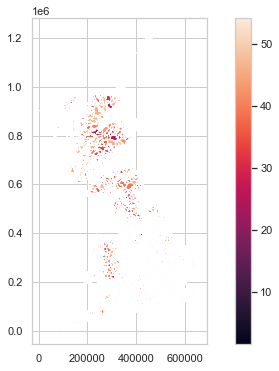

In [41]:
#map 
fig, ax = plt.subplots(1,1)

gdf.plot(column = 'AHAH',
        ax=ax, 
        legend=True)

### Barbour ABI Data

In [42]:
print(Utility['2018'])

0        0.00
1      426.66
2        0.00
3        0.00
4      392.62
        ...  
3946      NaN
3947      NaN
3948      NaN
3949      NaN
3950      NaN
Name: 2018, Length: 3951, dtype: float64


In [43]:
#Total value column is actual value, the yearly value is per million. Therefore all yearly values must be multiplied by 1m

#[Transport1,Transport2,Transport3,General,Primary,Secondary,University,Localhealth,Hospitals,Utility]

#years = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', 
#         '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 
#         '2019', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']

#Transport1[years] = Transport1[years]*1000000
#Transport2[years] = Transport2[years]*1000000
#Transport3[years] = Transport3[years]*1000000
#General[years] = General[years]*1000000
#Primary[years] = Primary[years]*1000000
#Secondary[years] = Secondary[years]*1000000
#University[years] = University[years]*1000000
#Localhealth[years] = Localhealth[years]*1000000
#Hospitals[years] = Hospitals[years]*1000000
#Utility[years] = Utility[years]*1000000

In [44]:
print(Utility['2018'])

0        0.00
1      426.66
2        0.00
3        0.00
4      392.62
        ...  
3946      NaN
3947      NaN
3948      NaN
3949      NaN
3950      NaN
Name: 2018, Length: 3951, dtype: float64


##### Spatial joining segmented project data by category to LSOAs

In [45]:
# create geodataframe from BABI data and reproject
BABIgdf = gpd.GeoDataFrame(
    BABI, geometry=gpd.points_from_xy(BABI.Long, BABI.Lat, crs='epsg:4326'))

BABIgdf = BABIgdf.to_crs('epsg:27700')

# spatial join with lsoas
BABIgdflsoas = gpd.sjoin(BABIgdf, lsoas, op='within', how='left')


In [46]:
# Transport 1 - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Transport1, geometry=gpd.points_from_xy(Transport1.Long, Transport1.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Transport1gdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [47]:
# Transport 2 - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Transport2, geometry=gpd.points_from_xy(Transport2.Long, Transport2.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Transport2gdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [48]:
# Transport 3 - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Transport3, geometry=gpd.points_from_xy(Transport3.Long, Transport3.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Transport3gdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [49]:
# General - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    General, geometry=gpd.points_from_xy(General.Long, General.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Generalgdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [50]:
# Primary - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Primary, geometry=gpd.points_from_xy(Primary.Long, Primary.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Primarygdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')


In [51]:
# Secondary - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Secondary, geometry=gpd.points_from_xy(Secondary.Long, Secondary.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Secondarygdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')


In [52]:
# University - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    University, geometry=gpd.points_from_xy(University.Long, University.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Universitygdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [53]:
# Localhealth - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Localhealth, geometry=gpd.points_from_xy(Localhealth.Long, Localhealth.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Localhealthgdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [54]:
# Hospitals - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Hospitals, geometry=gpd.points_from_xy(Hospitals.Long, Hospitals.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Hospitalsgdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [55]:
# Utility - create geodataframe from Transport1 data and reproject
Tempgdf = gpd.GeoDataFrame(
    Utility, geometry=gpd.points_from_xy(Utility.Long, Utility.Lat, crs='epsg:4326'))

Tempgdf = Tempgdf.to_crs('epsg:27700')

# spatial join with lsoas
Utilitygdflsoas = gpd.sjoin(Tempgdf, lsoas, op='within', how='left')

In [56]:
#[Transport1,Transport2,Transport3,General,Primary,Secondary,University,Localhealth,Hospitals,Utility]

##### Summing all spend per LSOA

In [57]:
#look at spending per lsoa and check correlations with socioeconomic indicators

#group by lsoa code (sum)
spending = BABIgdflsoas.groupby(by = 'Code').sum()
spending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
spending = lsoas.merge(spending, how='left', on = 'Code')

In [58]:
#Transport 1 - group spending by LSOA

#group by lsoa code (sum)
Transport1spending = Transport1gdflsoas.groupby(by = 'Code').sum()
Transport1spending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Transport1spending = lsoas.merge(spending, how='left', on = 'Code')

In [59]:
#Transport 2 - group spending by LSOA

#group by lsoa code (sum)
Transport2spending = Transport2gdflsoas.groupby(by = 'Code').sum()
Transport2spending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Transport2spending = lsoas.merge(spending, how='left', on = 'Code')

In [60]:
#Transport 3 - group spending by LSOA

#group by lsoa code (sum)
Transport3spending = Transport3gdflsoas.groupby(by = 'Code').sum()
Transport3spending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Transport3spending = lsoas.merge(spending, how='left', on = 'Code')

In [61]:
#General - group spending by LSOA

#group by lsoa code (sum)
Generalspending = Generalgdflsoas.groupby(by = 'Code').sum()
Generalspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Generalspending = lsoas.merge(spending, how='left', on = 'Code')

In [62]:
#Primary - group spending by LSOA

#group by lsoa code (sum)
Primaryspending = Primarygdflsoas.groupby(by = 'Code').sum()
Primaryspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Primaryspending = lsoas.merge(spending, how='left', on = 'Code')

In [63]:
#Secondary - group spending by LSOA

#group by lsoa code (sum)
Secondaryspending = Secondarygdflsoas.groupby(by = 'Code').sum()
Secondaryspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Secondaryspending = lsoas.merge(spending, how='left', on = 'Code')

In [64]:
#University - group spending by LSOA

#group by lsoa code (sum)
Universityspending = Universitygdflsoas.groupby(by = 'Code').sum()
Universityspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Universityspending = lsoas.merge(spending, how='left', on = 'Code')

In [65]:
#Localhealth - group spending by LSOA

#group by lsoa code (sum)
Localhealthspending = Localhealthgdflsoas.groupby(by = 'Code').sum()
Localhealthspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Localhealthspending = lsoas.merge(spending, how='left', on = 'Code')

In [66]:
#Hospitals- group spending by LSOA

#group by lsoa code (sum)
Hospitalsspending = Hospitalsgdflsoas.groupby(by = 'Code').sum()
Hospitalsspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Hospitalsspending = lsoas.merge(spending, how='left', on = 'Code')

In [67]:
#Utility - group spending by LSOA

#group by lsoa code (sum)
Utilityspending = Utilitygdflsoas.groupby(by = 'Code').sum()
Utilityspending.reset_index(inplace = True)

#merge with lsoas so that 0 spending per lsoa is 0
Utilityspending = lsoas.merge(spending, how='left', on = 'Code')

In [68]:
#Transport1, Transport2, Transport3, Generalspending, Primaryspending, Secondaryspending, Universityspending, Localhealthspending, Hospitalsspending, Utilityspending

#### Scaling value of pound


The infrastructure data must be wrangled into a format that includes total past spending, scaled to represent 2021 £ value, and total projected spending (which is assumed to be represented in 2021 £ value), *per sector*. The £scaling factors have been pulled from the ONS July 2021.


In [69]:
#convert NaNs to 0s

years = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', 
         '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 
         '2019', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']

Transport1spending[years] = Transport1spending[years].fillna(0)
Transport2spending[years] = Transport2spending[years].fillna(0)
Transport3spending[years] = Transport3spending[years].fillna(0)
Generalspending[years] = Generalspending[years].fillna(0)
Primaryspending[years] = Primaryspending[years].fillna(0)
Secondaryspending[years] = Secondaryspending[years].fillna(0)
Universityspending[years] = Universityspending[years].fillna(0)
Localhealthspending[years] = Localhealthspending[years].fillna(0)
Hospitalsspending[years] = Hospitalsspending[years].fillna(0)
Utilityspending[years] = Utilityspending[years].fillna(0)

In [70]:
#drop CPI row

CPI = CPI.drop(CPI.index[0])


CPI.head()

,Year,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Scaling Factor,2.10,2.00,1.80,1.80,1.70,1.70,1.60,1.60,1.60,...,1.10,1.10,1.10,1.10,1.10,1.10,1.00,1.00,1.00,1.00


In [71]:
#Multiply columns by single values

#1995

n=CPI.iloc[0]['1995']

Transport1spending['1995'] = Transport1spending['1995']*n
Transport2spending['1995'] = Transport2spending['1995']*n
Transport3spending['1995'] = Transport3spending['1995']*n
Generalspending['1995'] = Generalspending['1995']*n
Primaryspending['1995'] = Primaryspending['1995']*n
Secondaryspending['1995'] = Secondaryspending['1995']*n
Universityspending['1995'] = Universityspending['1995']*n
Localhealthspending['1995'] = Localhealthspending['1995']*n
Hospitalsspending['1995'] = Hospitalsspending['1995']*n
Utilityspending['1995'] = Utilityspending['1995']*n

Transport1spending.head()

,Code,Name_x,Shape_Leng,Shape_Area,geometry_x,Name_y,Shape_Leng_x,Shape_Area_x,geometry_y,Barbour ref,...,2024,2025,2026,2027,2028,2029,2030,index_right,Shape_Leng_y,Shape_Area_y
0,E01000001,City of London 001A,"2,635.77","129,865.31","POLYGON ((532151.537 181867.433, 532152.500 18...",City of London 001A,"2,635.77","129,865.31","POLYGON ((532151.537 181867.433, 532152.500 18...","897,575,392.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"216,132.98","10,648,955.78"
1,E01000002,City of London 001B,"2,707.88","228,419.63","POLYGON ((532634.497 181926.016, 532632.048 18...",City of London 001B,"2,707.88","228,419.63","POLYGON ((532634.497 181926.016, 532632.048 18...","103,453,999.00",...,8.34,4.15,0.00,0.00,0.00,0.00,0.00,9.00,"24,370.94","2,055,776.71"
2,E01000003,City of London 001C,"1,224.64","59,054.35","POLYGON ((532153.703 182165.155, 532158.250 18...",City of London 001C,"1,224.64","59,054.35","POLYGON ((532153.703 182165.155, 532158.250 18...",NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN
3,E01000005,City of London 001E,"2,275.81","189,577.71","POLYGON ((533619.062 181402.364, 533639.868 18...",City of London 001E,"2,275.81","189,577.71","POLYGON ((533619.062 181402.364, 533639.868 18...","35,957,607.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,"6,827.42","568,733.13"
4,E01000006,Barking and Dagenham 016A,"1,966.09","146,537.00","POLYGON ((545126.852 184310.838, 545145.213 18...",Barking and Dagenham 016A,"1,966.09","146,537.00","POLYGON ((545126.852 184310.838, 545145.213 18...",NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN


In [72]:
#1996

n=CPI.iloc[0]['1996']

Transport1spending['1996'] = Transport1spending['1996']*n
Transport2spending['1996'] = Transport2spending['1996']*n
Transport3spending['1996'] = Transport3spending['1996']*n
Generalspending['1996'] = Generalspending['1996']*n
Primaryspending['1996'] = Primaryspending['1996']*n
Secondaryspending['1996'] = Secondaryspending['1996']*n
Universityspending['1996'] = Universityspending['1996']*n
Localhealthspending['1996'] = Localhealthspending['1996']*n
Hospitalsspending['1996'] = Hospitalsspending['1996']*n
Utilityspending['1996'] = Utilityspending['1996']*n



In [73]:
#1997

n=CPI.iloc[0]['1997']

Transport1spending['1997'] = Transport1spending['1997']*n
Transport2spending['1997'] = Transport2spending['1997']*n
Transport3spending['1997'] = Transport3spending['1997']*n
Generalspending['1997'] = Generalspending['1997']*n
Primaryspending['1997'] = Primaryspending['1997']*n
Secondaryspending['1997'] = Secondaryspending['1997']*n
Universityspending['1997'] = Universityspending['1997']*n
Localhealthspending['1997'] = Localhealthspending['1997']*n
Hospitalsspending['1997'] = Hospitalsspending['1997']*n
Utilityspending['1997'] = Utilityspending['1997']*n

In [74]:
#Transport1spending, Transport2, Transport3, Generalspending, Primaryspending, Secondaryspending, Universityspending, Localhealthspending, Hospitalsspending, Utilityspending

In [75]:
#1998

n=CPI.iloc[0]['1998']

Transport1spending['1998'] = Transport1spending['1998']*n
Transport2spending['1998'] = Transport2spending['1998']*n
Transport3spending['1998'] = Transport3spending['1998']*n
Generalspending['1998'] = Generalspending['1998']*n
Primaryspending['1998'] = Primaryspending['1998']*n
Secondaryspending['1998'] = Secondaryspending['1998']*n
Universityspending['1998'] = Universityspending['1998']*n
Localhealthspending['1998'] = Localhealthspending['1998']*n
Hospitalsspending['1998'] = Hospitalsspending['1998']*n
Utilityspending['1998'] = Utilityspending['1998']*n

In [76]:
#1999

n=CPI.iloc[0]['1999']

Transport1spending['1999'] = Transport1spending['1999']*n
Transport2spending['1999'] = Transport2spending['1999']*n
Transport3spending['1999'] = Transport3spending['1999']*n
Generalspending['1999'] = Generalspending['1999']*n
Primaryspending['1999'] = Primaryspending['1999']*n
Secondaryspending['1999'] = Secondaryspending['1999']*n
Universityspending['1999'] = Universityspending['1999']*n
Localhealthspending['1999'] = Localhealthspending['1999']*n
Hospitalsspending['1999'] = Hospitalsspending['1999']*n
Utilityspending['1999'] = Utilityspending['1999']*n

In [77]:
#2000

n=CPI.iloc[0]['2000']

Transport1spending['2000'] = Transport1spending['2000']*n
Transport2spending['2000'] = Transport2spending['2000']*n
Transport3spending['2000'] = Transport3spending['2000']*n
Generalspending['2000'] = Generalspending['2000']*n
Primaryspending['2000'] = Primaryspending['2000']*n
Secondaryspending['2000'] = Secondaryspending['2000']*n
Universityspending['2000'] = Universityspending['2000']*n
Localhealthspending['2000'] = Localhealthspending['2000']*n
Hospitalsspending['2000'] = Hospitalsspending['2000']*n
Utilityspending['2000'] = Utilityspending['2000']*n

In [78]:
#2001

n=CPI.iloc[0]['2001']

Transport1spending['2001'] = Transport1spending['2001']*n
Transport2spending['2001'] = Transport2spending['2001']*n
Transport3spending['2001'] = Transport3spending['2001']*n
Generalspending['2001'] = Generalspending['2001']*n
Primaryspending['2001'] = Primaryspending['2001']*n
Secondaryspending['2001'] = Secondaryspending['2001']*n
Universityspending['2001'] = Universityspending['2001']*n
Localhealthspending['2001'] = Localhealthspending['2001']*n
Hospitalsspending['2001'] = Hospitalsspending['2001']*n
Utilityspending['2001'] = Utilityspending['2001']*n

In [79]:
#2002

n=CPI.iloc[0]['2002']

Transport1spending['2002'] = Transport1spending['2002']*n
Transport2spending['2002'] = Transport2spending['2002']*n
Transport3spending['2002'] = Transport3spending['2002']*n
Generalspending['2002'] = Generalspending['2002']*n
Primaryspending['2002'] = Primaryspending['2002']*n
Secondaryspending['2002'] = Secondaryspending['2002']*n
Universityspending['2002'] = Universityspending['2002']*n
Localhealthspending['2002'] = Localhealthspending['2002']*n
Hospitalsspending['2002'] = Hospitalsspending['2002']*n
Utilityspending['2002'] = Utilityspending['2002']*n

In [80]:
#2003

n=CPI.iloc[0]['2003']

Transport1spending['2003'] = Transport1spending['2003']*n
Transport2spending['2003'] = Transport2spending['2003']*n
Transport3spending['2003'] = Transport3spending['2003']*n
Generalspending['2003'] = Generalspending['2003']*n
Primaryspending['2003'] = Primaryspending['2003']*n
Secondaryspending['2003'] = Secondaryspending['2003']*n
Universityspending['2003'] = Universityspending['2003']*n
Localhealthspending['2003'] = Localhealthspending['2003']*n
Hospitalsspending['2003'] = Hospitalsspending['2003']*n
Utilityspending['2003'] = Utilityspending['2003']*n

In [81]:
#2004

n=CPI.iloc[0]['2004']

Transport1spending['2004'] = Transport1spending['2004']*n
Transport2spending['2004'] = Transport2spending['2004']*n
Transport3spending['2004'] = Transport3spending['2004']*n
Generalspending['2004'] = Generalspending['2004']*n
Primaryspending['2004'] = Primaryspending['2004']*n
Secondaryspending['2004'] = Secondaryspending['2004']*n
Universityspending['2004'] = Universityspending['2004']*n
Localhealthspending['2004'] = Localhealthspending['2004']*n
Hospitalsspending['2004'] = Hospitalsspending['2004']*n
Utilityspending['2004'] = Utilityspending['2004']*n

In [82]:
#2005

n=CPI.iloc[0]['2005']

Transport1spending['2005'] = Transport1spending['2005']*n
Transport2spending['2005'] = Transport2spending['2005']*n
Transport3spending['2005'] = Transport3spending['2005']*n
Generalspending['2005'] = Generalspending['2005']*n
Primaryspending['2005'] = Primaryspending['2005']*n
Secondaryspending['2005'] = Secondaryspending['2005']*n
Universityspending['2005'] = Universityspending['2005']*n
Localhealthspending['2005'] = Localhealthspending['2005']*n
Hospitalsspending['2005'] = Hospitalsspending['2005']*n
Utilityspending['2005'] = Utilityspending['2005']*n

In [83]:
#2006

n=CPI.iloc[0]['2006']

Transport1spending['2006'] = Transport1spending['2006']*n
Transport2spending['2006'] = Transport2spending['2006']*n
Transport3spending['2006'] = Transport3spending['2006']*n
Generalspending['2006'] = Generalspending['2006']*n
Primaryspending['2006'] = Primaryspending['2006']*n
Secondaryspending['2006'] = Secondaryspending['2006']*n
Universityspending['2006'] = Universityspending['2006']*n
Localhealthspending['2006'] = Localhealthspending['2006']*n
Hospitalsspending['2006'] = Hospitalsspending['2006']*n
Utilityspending['2006'] = Utilityspending['2006']*n

In [84]:
#2007

n=CPI.iloc[0]['2007']

Transport1spending['2007'] = Transport1spending['2007']*n
Transport2spending['2007'] = Transport2spending['2007']*n
Transport3spending['2007'] = Transport3spending['2007']*n
Generalspending['2007'] = Generalspending['2007']*n
Primaryspending['2007'] = Primaryspending['2007']*n
Secondaryspending['2007'] = Secondaryspending['2007']*n
Universityspending['2007'] = Universityspending['2007']*n
Localhealthspending['2007'] = Localhealthspending['2007']*n
Hospitalsspending['2007'] = Hospitalsspending['2007']*n
Utilityspending['2007'] = Utilityspending['2007']*n

In [85]:
#2008

n=CPI.iloc[0]['2008']

Transport1spending['2008'] = Transport1spending['2008']*n
Transport2spending['2008'] = Transport2spending['2008']*n
Transport3spending['2008'] = Transport3spending['2008']*n
Generalspending['2008'] = Generalspending['2008']*n
Primaryspending['2008'] = Primaryspending['2008']*n
Secondaryspending['2008'] = Secondaryspending['2008']*n
Universityspending['2008'] = Universityspending['2008']*n
Localhealthspending['2008'] = Localhealthspending['2008']*n
Hospitalsspending['2008'] = Hospitalsspending['2008']*n
Utilityspending['2008'] = Utilityspending['2008']*n

In [86]:
#2009

n=CPI.iloc[0]['2009']

Transport1spending['2009'] = Transport1spending['2009']*n
Transport2spending['2009'] = Transport2spending['2009']*n
Transport3spending['2009'] = Transport3spending['2009']*n
Generalspending['2009'] = Generalspending['2009']*n
Primaryspending['2009'] = Primaryspending['2009']*n
Secondaryspending['2009'] = Secondaryspending['2009']*n
Universityspending['2009'] = Universityspending['2009']*n
Localhealthspending['2009'] = Localhealthspending['2009']*n
Hospitalsspending['2009'] = Hospitalsspending['2009']*n
Utilityspending['2009'] = Utilityspending['2009']*n

In [87]:
#2010

n=CPI.iloc[0]['2010']

Transport1spending['2010'] = Transport1spending['2010']*n
Transport2spending['2010'] = Transport2spending['2010']*n
Transport3spending['2010'] = Transport3spending['2010']*n
Generalspending['2010'] = Generalspending['2010']*n
Primaryspending['2010'] = Primaryspending['2010']*n
Secondaryspending['2010'] = Secondaryspending['2010']*n
Universityspending['2010'] = Universityspending['2010']*n
Localhealthspending['2010'] = Localhealthspending['2010']*n
Hospitalsspending['2010'] = Hospitalsspending['2010']*n
Utilityspending['2010'] = Utilityspending['2010']*n

In [88]:
#2011

n=CPI.iloc[0]['2011']

Transport1spending['2011'] = Transport1spending['2011']*n
Transport2spending['2011'] = Transport2spending['2011']*n
Transport3spending['2011'] = Transport3spending['2011']*n
Generalspending['2011'] = Generalspending['2011']*n
Primaryspending['2011'] = Primaryspending['2011']*n
Secondaryspending['2011'] = Secondaryspending['2011']*n
Universityspending['2011'] = Universityspending['2011']*n
Localhealthspending['2011'] = Localhealthspending['2011']*n
Hospitalsspending['2011'] = Hospitalsspending['2011']*n
Utilityspending['2011'] = Utilityspending['2011']*n

In [89]:
#2012

n=CPI.iloc[0]['2012']

Transport1spending['2012'] = Transport1spending['2012']*n
Transport2spending['2012'] = Transport2spending['2012']*n
Transport3spending['2012'] = Transport3spending['2012']*n
Generalspending['2012'] = Generalspending['2012']*n
Primaryspending['2012'] = Primaryspending['2012']*n
Secondaryspending['2012'] = Secondaryspending['2012']*n
Universityspending['2012'] = Universityspending['2012']*n
Localhealthspending['2012'] = Localhealthspending['2012']*n
Hospitalsspending['2012'] = Hospitalsspending['2012']*n
Utilityspending['2012'] = Utilityspending['2012']*n

In [90]:
#2013

n=CPI.iloc[0]['2013']

Transport1spending['2013'] = Transport1spending['2013']*n
Transport2spending['2013'] = Transport2spending['2013']*n
Transport3spending['2013'] = Transport3spending['2013']*n
Generalspending['2013'] = Generalspending['2013']*n
Primaryspending['2013'] = Primaryspending['2013']*n
Secondaryspending['2013'] = Secondaryspending['2013']*n
Universityspending['2013'] = Universityspending['2013']*n
Localhealthspending['2013'] = Localhealthspending['2013']*n
Hospitalsspending['2013'] = Hospitalsspending['2013']*n
Utilityspending['2013'] = Utilityspending['2013']*n

In [91]:
#2014

n=CPI.iloc[0]['2014']

Transport1spending['2014'] = Transport1spending['2014']*n
Transport2spending['2014'] = Transport2spending['2014']*n
Transport3spending['2014'] = Transport3spending['2014']*n
Generalspending['2014'] = Generalspending['2014']*n
Primaryspending['2014'] = Primaryspending['2014']*n
Secondaryspending['2014'] = Secondaryspending['2014']*n
Universityspending['2014'] = Universityspending['2014']*n
Localhealthspending['2014'] = Localhealthspending['2014']*n
Hospitalsspending['2014'] = Hospitalsspending['2014']*n
Utilityspending['2014'] = Utilityspending['2014']*n

In [92]:
#2015

n=CPI.iloc[0]['2015']

Transport1spending['2015'] = Transport1spending['2015']*n
Transport2spending['2015'] = Transport2spending['2015']*n
Transport3spending['2015'] = Transport3spending['2015']*n
Generalspending['2015'] = Generalspending['2015']*n
Primaryspending['2015'] = Primaryspending['2015']*n
Secondaryspending['2015'] = Secondaryspending['2015']*n
Universityspending['2015'] = Universityspending['2015']*n
Localhealthspending['2015'] = Localhealthspending['2015']*n
Hospitalsspending['2015'] = Hospitalsspending['2015']*n
Utilityspending['2015'] = Utilityspending['2015']*n

In [93]:
#2016

n=CPI.iloc[0]['2016']

Transport1spending['2016'] = Transport1spending['2016']*n
Transport2spending['2016'] = Transport2spending['2016']*n
Transport3spending['2016'] = Transport3spending['2016']*n
Generalspending['2016'] = Generalspending['2016']*n
Primaryspending['2016'] = Primaryspending['2016']*n
Secondaryspending['2016'] = Secondaryspending['2016']*n
Universityspending['2016'] = Universityspending['2016']*n
Localhealthspending['2016'] = Localhealthspending['2016']*n
Hospitalsspending['2016'] = Hospitalsspending['2016']*n
Utilityspending['2016'] = Utilityspending['2016']*n

In [94]:
#2017

n=CPI.iloc[0]['2017']

Transport1spending['2017'] = Transport1spending['2017']*n
Transport2spending['2017'] = Transport2spending['2017']*n
Transport3spending['2017'] = Transport3spending['2017']*n
Generalspending['2017'] = Generalspending['2017']*n
Primaryspending['2017'] = Primaryspending['2017']*n
Secondaryspending['2017'] = Secondaryspending['2017']*n
Universityspending['2017'] = Universityspending['2017']*n
Localhealthspending['2017'] = Localhealthspending['2017']*n
Hospitalsspending['2017'] = Hospitalsspending['2017']*n
Utilityspending['2017'] = Utilityspending['2017']*n

In [95]:
#2018

n=CPI.iloc[0]['2018']

Transport1spending['2018'] = Transport1spending['2018']*n
Transport2spending['2018'] = Transport2spending['2018']*n
Transport3spending['2018'] = Transport3spending['2018']*n
Generalspending['2018'] = Generalspending['2018']*n
Primaryspending['2018'] = Primaryspending['2018']*n
Secondaryspending['2018'] = Secondaryspending['2018']*n
Universityspending['2018'] = Universityspending['2018']*n
Localhealthspending['2018'] = Localhealthspending['2018']*n
Hospitalsspending['2018'] = Hospitalsspending['2018']*n
Utilityspending['2018'] = Utilityspending['2018']*n

In [96]:
#2019

n=CPI.iloc[0]['2019']

Transport1spending['2019'] = Transport1spending['2019']*n
Transport2spending['2019'] = Transport2spending['2019']*n
Transport3spending['2019'] = Transport3spending['2019']*n
Generalspending['2019'] = Generalspending['2019']*n
Primaryspending['2019'] = Primaryspending['2019']*n
Secondaryspending['2019'] = Secondaryspending['2019']*n
Universityspending['2019'] = Universityspending['2019']*n
Localhealthspending['2019'] = Localhealthspending['2019']*n
Hospitalsspending['2019'] = Hospitalsspending['2019']*n
Utilityspending['2019'] = Utilityspending['2019']*n

In [97]:
#2020

n=CPI.iloc[0]['2020']

Transport1spending['2020'] = Transport1spending['2020']*n
Transport2spending['2020'] = Transport2spending['2020']*n
Transport3spending['2020'] = Transport3spending['2020']*n
Generalspending['2020'] = Generalspending['2020']*n
Primaryspending['2020'] = Primaryspending['2020']*n
Secondaryspending['2020'] = Secondaryspending['2020']*n
Universityspending['2020'] = Universityspending['2020']*n
Localhealthspending['2020'] = Localhealthspending['2020']*n
Hospitalsspending['2020'] = Hospitalsspending['2020']*n
Utilityspending['2020'] = Utilityspending['2020']*n

In [98]:
#2021

#n=CPI['2021']
n = CPI.iloc[0]['2021']

Transport1spending['2021'] = Transport1spending['2021']*n
Transport2spending['2021'] = Transport2spending['2021']*n
Transport3spending['2021'] = Transport3spending['2021']*n
Generalspending['2021'] = Generalspending['2021']*n
Primaryspending['2021'] = Primaryspending['2021']*n
Secondaryspending['2021'] = Secondaryspending['2021']*n
Universityspending['2021'] = Universityspending['2021']*n
Localhealthspending['2021'] = Localhealthspending['2021']*n
Hospitalsspending['2021'] = Hospitalsspending['2021']*n
Utilityspending['2021'] = Utilityspending['2021']*n

In [99]:
#check shapes of each spending dataframe - they should all represent all LSOAs
print(Transport1spending.shape)
print(Transport2spending.shape)
print(Transport3spending.shape)
print(Generalspending.shape)
print(Primaryspending.shape)
print(Secondaryspending.shape)
print(Universityspending.shape)
print(Localhealthspending.shape)
print(Hospitalsspending.shape)
print(Utilityspending.shape)

(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)
(41729, 53)


#### Sum past and future spending per category

In [100]:
#set years that are future and past

futureyears = ['2021','2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']

pastyears = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', 
             '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', 
             '2015', '2016', '2017', '2018', '2019', '2020']

In [101]:
Transport1spending['FutureValue'] = Transport1spending[futureyears].sum(axis=1)
Transport2spending['FutureValue'] = Transport2spending[futureyears].sum(axis=1)
Transport3spending['FutureValue'] = Transport3spending[futureyears].sum(axis=1)
Generalspending['FutureValue'] = Generalspending[futureyears].sum(axis=1)
Primaryspending['FutureValue'] = Primaryspending[futureyears].sum(axis=1)
Secondaryspending['FutureValue'] = Secondaryspending[futureyears].sum(axis=1)
Universityspending['FutureValue'] = Universityspending[futureyears].sum(axis=1)
Localhealthspending['FutureValue'] = Localhealthspending[futureyears].sum(axis=1)
Hospitalsspending['FutureValue'] = Hospitalsspending[futureyears].sum(axis=1)
Utilityspending['FutureValue'] = Utilityspending[futureyears].sum(axis=1)

In [102]:
Transport1spending['PastValue'] = Transport1spending[pastyears].sum(axis=1)
Transport2spending['PastValue'] = Transport2spending[pastyears].sum(axis=1)
Transport3spending['PastValue'] = Transport3spending[pastyears].sum(axis=1)
Generalspending['PastValue'] = Generalspending[pastyears].sum(axis=1)
Primaryspending['PastValue'] = Primaryspending[pastyears].sum(axis=1)
Secondaryspending['PastValue'] = Secondaryspending[pastyears].sum(axis=1)
Universityspending['PastValue'] = Universityspending[pastyears].sum(axis=1)
Localhealthspending['PastValue'] = Localhealthspending[pastyears].sum(axis=1)
Hospitalsspending['PastValue'] = Hospitalsspending[pastyears].sum(axis=1)
Utilityspending['PastValue'] = Utilityspending[pastyears].sum(axis=1)

In [103]:
#Create one transport spending dataframe

frames = [Transport1spending, Transport2spending, Transport3spending]

Transportspendingall = pd.concat(frames)


In [104]:
#CHECK
#Hospitalsspending.to_csv('hospitalscheck.csv')

In [105]:
#drop columns and tidy up
Transport1spending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Transport2spending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Transport3spending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Generalspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Primaryspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Secondaryspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Universityspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Localhealthspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Hospitalsspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)
Utilityspending.drop(['index_right','Shape_Leng_y', 'Shape_Area_y', 'Barbour ref', 'Project Link ID'], axis=1, inplace = True)


## Creating Spatial Area of Benefit

Spatial Area of Benefit per category:  
  
- Transport 1: Local Authority  
- Transport 2: NUTS2 
- Transport 3: NUTS1  
  
- General/Essential: Local Authority  
- Primary and Nursery: Local Authority  
- Secondary and Special: Local Authority  
- University/ Colleges and Training: NUTS2
- Local healthcare: Local Authority  
- Hospitals: Local Authority  
- Utility: Local Authority  

In [106]:
#Merging lookup with all dataframes to provide different geographic locations
Transport1spending = Transport1spending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Transport2spending = Transport2spending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Transport3spending = Transport3spending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Generalspending = Generalspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Primaryspending = Primaryspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Secondaryspending = Secondaryspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Universityspending = Universityspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Localhealthspending = Localhealthspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Hospitalsspending = Hospitalsspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')
Utilityspending = Utilityspending.merge(NUTSLookups, left_on='Code', right_on='LSOA Code')

In [107]:
#drop the value by year

years= ['2021','2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 
               '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', 
             '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', 
             '2015', '2016', '2017', '2018', '2019', '2020']

Transport1spending.drop(years, axis = 1, inplace = True)
Transport2spending.drop(years, axis = 1, inplace = True)
Transport3spending.drop(years, axis = 1, inplace = True)
Generalspending.drop(years, axis = 1, inplace = True)
Primaryspending.drop(years, axis = 1, inplace = True)
Secondaryspending.drop(years, axis = 1, inplace = True)
Universityspending.drop(years, axis = 1, inplace = True)
Localhealthspending.drop(years, axis = 1, inplace = True)
Hospitalsspending.drop(years, axis = 1, inplace = True)
Utilityspending.drop(years, axis = 1, inplace = True)

In [108]:
#check shapes of each spending dataframe - they should all represent all LSOAs
print(Transport1spending.shape)
print(Transport2spending.shape)
print(Transport3spending.shape)
print(Generalspending.shape)
print(Primaryspending.shape)
print(Secondaryspending.shape)
print(Universityspending.shape)
print(Localhealthspending.shape)
print(Hospitalsspending.shape)
print(Utilityspending.shape)

(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)
(41729, 29)


In [109]:
#Aggregating value per associated area
Transport1 = Transport1spending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()
Transport2 = Transport2spending.groupby(by = 'NUTS2 Name').sum().reset_index()
Transport3 = Transport3spending.groupby(by = 'NUTS1 Name').sum().reset_index()
General = Generalspending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()
Primary = Primaryspending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()
Secondary = Secondaryspending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()
University = Universityspending.groupby(by = 'NUTS2 Name').sum().reset_index()
Localhealth = Localhealthspending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()
Hospitals = Hospitalsspending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()
Utility = Utilityspending.groupby(by = 'LA Code (2019 boundaries)').sum().reset_index()

In [110]:
#check shapes of each spending dataframe - they should all have different numbers of rows
print(Transport1.shape)
print(Transport2.shape)
print(Transport3.shape)
print(General.shape)
print(Primary.shape)
print(Secondary.shape)
print(University.shape)
print(Localhealth.shape)
print(Hospitals.shape)
print(Utility.shape)

(371, 11)
(42, 11)
(11, 11)
(371, 11)
(371, 11)
(371, 11)
(42, 11)
(371, 11)
(371, 11)
(371, 11)


In [111]:
Localhealth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LA Code (2019 boundaries)  371 non-null    object 
 1   Shape_Leng                 371 non-null    float64
 2   Shape_Area                 371 non-null    float64
 3   Shape_Leng_x               371 non-null    float64
 4   Shape_Area_x               371 non-null    float64
 5   Long                       371 non-null    float64
 6   Lat                        371 non-null    float64
 7   Value                      371 non-null    float64
 8   FutureValue                371 non-null    float64
 9   PastValue                  371 non-null    float64
 10  All Ages                   371 non-null    int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 32.0+ KB


In [112]:
#Redistributing value back to LSOA level - need to be merged ON the geography it needs to be redistributed to!
Transport1spending = Transport1spending.merge(Transport1, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')
Transport2spending = Transport2spending.merge(Transport2, left_on='NUTS2 Name', right_on='NUTS2 Name')
Transport3spending = Transport3spending.merge(Transport3, left_on='NUTS1 Name', right_on='NUTS1 Name')
Generalspending = Generalspending.merge(General, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')
Primaryspending = Primaryspending.merge(Primary, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')
Secondaryspending = Secondaryspending.merge(Secondary, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')
Universityspending = Universityspending.merge(University, left_on='NUTS2 Name', right_on='NUTS2 Name')
Localhealthspending = Localhealthspending.merge(Localhealth, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')
Hospitalsspending = Hospitalsspending.merge(Hospitals, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')
Utilityspending = Utilityspending.merge(Utility, left_on='LA Code (2019 boundaries)', right_on='LA Code (2019 boundaries)')

In [113]:
#check shapes of each spending dataframe - they should all represent all LSOAs
print(Transport1spending.shape)
print(Transport2spending.shape)
print(Transport3spending.shape)
print(Generalspending.shape)
print(Primaryspending.shape)
print(Secondaryspending.shape)
print(Universityspending.shape)
print(Localhealthspending.shape)
print(Hospitalsspending.shape)
print(Utilityspending.shape)

(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)
(41729, 39)


In [114]:
#Tidying up

#remove duplicate columns

columns = ['Name_x', 'Name_y', 'geometry_x', 'Shape_Area_x', 'Shape_Leng_x', 
           'Lat_x', 'Long_x', 'Shape_Leng_x_x', 'Shape_Area_x_x', 'Shape_Leng_x_y', 
           'Value_x', 'Value_y', 'Shape_Area_x_y', 'All Ages_x', 'County Code', 'County Name',
          'Region Code', 'Region Name', 'NUTS1 Code', 'NUTS2 Code', 'NUTS3 Code']

Transport1spending.drop(columns, axis=1, inplace = True)
Transport2spending.drop(columns, axis = 1, inplace = True)
Transport3spending.drop(columns, axis = 1, inplace = True)
Generalspending.drop(columns, axis = 1, inplace = True)
Primaryspending.drop(columns, axis = 1, inplace = True)
Secondaryspending.drop(columns, axis = 1, inplace = True)
Universityspending.drop(columns, axis = 1, inplace = True)
Localhealthspending.drop(columns, axis = 1, inplace = True)
Hospitalsspending.drop(columns, axis = 1, inplace = True)
Utilityspending.drop(columns, axis = 1, inplace = True)

#renaming columns
Transport1spending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Transport2spending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Transport3spending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Generalspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Primaryspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Secondaryspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Universityspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Localhealthspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Hospitalsspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)
Utilityspending.rename(columns = {'geometry_y':'geometry', 'FutureValue_x':'FutureValueLSOA',
                                  'FutureValue_y':'FutureValueSAB', 'PastValue_x':'PastValueLSOA',
                                 'PastValue_y' : 'PastValueSAB', 'All Ages_y':'Populations'}, inplace = True)

In [115]:
Transport1spending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41729 entries, 0 to 41728
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Code                       41729 non-null  object  
 1   geometry                   41729 non-null  geometry
 2   FutureValueLSOA            41729 non-null  float64 
 3   PastValueLSOA              41729 non-null  float64 
 4   LSOA Code                  41729 non-null  object  
 5   LSOA Name                  41729 non-null  object  
 6   LA Code (2019 boundaries)  41729 non-null  object  
 7   LA name (2019 boundaries)  41729 non-null  object  
 8   NUTS3 Name                 41277 non-null  object  
 9   NUTS2 Name                 41729 non-null  object  
 10  NUTS1 Name                 41729 non-null  object  
 11  Shape_Leng_y               41729 non-null  float64 
 12  Shape_Area_y               41729 non-null  float64 
 13  Long_y                     4172

## Exporting Data

In [117]:
#Hospitalsspending.to_csv('hospitalscheck.csv')

Transport1spending.to_csv('ExportedData/Transport1-exported.csv')
Transport2spending.to_csv('ExportedData/Transport2-exported.csv')
Transport3spending.to_csv('ExportedData/Transport3-exported.csv')
Generalspending.to_csv('ExportedData/General-exported.csv')
Primaryspending.to_csv('ExportedData/Primary-exported.csv')
Secondaryspending.to_csv('ExportedData/Secondary-exported.csv')
Universityspending.to_csv('ExportedData/University-exported.csv')
Localhealthspending.to_csv('ExportedData/Localhealth-exported.csv')
Hospitalsspending.to_csv('ExportedData/Hospitals-exported.csv')
Utilityspending.to_csv('ExportedData/Utility-exported.csv')


## Infrastructure Data Exploratory Analysis

## Value Analysis

In [ ]:
# histogram of value of each project

plt.style.use('seaborn-white')

Values = BABI['Value']

plt.hist(Values, alpha=0.5, bins=1000,
         histtype='stepfilled', color='steelblue');

In [ ]:
# density plot of value of project

Values = BABI[['Value','Barbour ref']]

#sort values
Values.sort_values(by=['Value'],ascending=False, inplace=True)
Values.reset_index(inplace = True)      #reset index  


#create index column
Values['index'] = Values.index


#summary stats
Values.describe()


In [ ]:
#plot the graph with log scale
splot = sns.regplot(x="index", y="Value", 
                    scatter_kws={'alpha':0.15},
                    data=Values, fit_reg=False)
splot.set(xscale="log")

In [ ]:
# proportions of value in each category
BABIsector = BABI.groupby(by = 'Primary category').sum()
BABIsector.reset_index(inplace = True)

#graph of value
ax = sns.barplot(y="Value", x= 'Primary category', data=BABIsector,
                 palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

None

In [ ]:
# proportions of value in each ECMR sector
BABIsector = BABI.groupby(by = 'ECMR Sector').sum()
BABIsector.reset_index(inplace = True)

#graph of value
ax = sns.barplot(y="Value", x="ECMR Sector", data=BABIsector,
                 palette="Blues_d")
plt.xticks(rotation=45)

None

In [ ]:
# proportions of value in each primary sector
BABIsector = BABI.groupby(by = 'Primary sector').sum() #overwriting variable for selected sector type
BABIsector.reset_index(inplace = True)

#graph of value
ax = sns.barplot(y="Value", x="Primary sector", data=BABIsector,
                 palette="Blues_d")

plt.xticks(rotation=90)

None

In [ ]:
#map the sectors
ax = BABIgdflsoas.plot(column='Primary sector', markersize=0.5, alpha=0.5, figsize=(10,8))
lsoas.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0);
#add legend

In [ ]:
#map the sectors
#BABIgdflsoas.plot(column='Value', cmap = 'plasma', scheme ='FisherJenks', markersize=0.5, alpha=0.5, legend=True, figsize=(10,8));

In [ ]:
#map the sectors
spending.plot(column='Value', cmap = 'plasma', scheme ='FisherJenks', markersize=0.5, alpha=0.5, legend=True, figsize=(10,8));

In [ ]:
sns.set_theme(style="ticks")
g = sns.JointGrid(data=BABI, y='Value', x='Start Year', marginal_ticks=True)


# Create an inset legend for the histogram colorbar
cax = g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

## Considering Relationships between Economic and Social Metrics

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='AHAH', x = 'IMD Rank', data=df, kind='reg', height=12)
ax.set_axis_labels(ylabel='AHAH', xlabel='IMD', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='AHAH', x = 'GDP2019LSOA', data=df, kind='reg', height=12)
ax.set_axis_labels(ylabel='AHAH', xlabel='GDP', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='AHAH', x = 'GVA2016LSOA', data=df, kind='reg', height=12)
ax.set_axis_labels(ylabel='AHAH', xlabel='GVA', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='IMD Rank', x = 'GDP2019LSOA', data=df, kind='reg', height=12)
ax.set_axis_labels(ylabel='IMD', xlabel='GDP', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='IMD Rank', x = 'GVA2016LSOA', data=df, kind='reg', height=12)
ax.set_axis_labels(ylabel='IMD', xlabel='GVA', fontsize=16)
plt.show()

## Considering Relationships Between Economic and Social Metrics

In [ ]:
spending.head()

In [ ]:
#merge spending with economic variables
alldata = gdf.merge(spending, how = 'left', on = 'Code')
alldata.head()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='IMD Rank', x = 'Value', data=alldata, kind='reg', height=12)
ax.set_axis_labels(ylabel='IMD', xlabel='Value', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='AHAH', x = 'Value', data=alldata, kind='reg', height=12)
ax.set_axis_labels(ylabel='AHAH', xlabel='Value', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='GVA2016LSOA', x = 'Value', data=alldata, kind='reg', height=12)
ax.set_axis_labels(ylabel='IMD', xlabel='Value', fontsize=16)
plt.show()

In [ ]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1.3)
ax = sns.jointplot(y='GDP2019LSOA', x = 'Value', data=alldata, kind='reg', height=12)
ax.set_axis_labels(ylabel='IMD', xlabel='Value', fontsize=16)
plt.show()